**Tâche : Importation des bibliothèques de base**

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM, SimpleRNN

2024-03-24 09:10:23.075302: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-24 09:10:23.270886: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-24 09:10:24.155909: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-24 09:10:26.018792: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df = pd.read_csv('energy_antananarivo_cleaned.csv',index_col='date',parse_dates=True)

In [3]:
df.head()

,tot_nb_dmd,tot_energy
date,,
2000-01-01,1480,0.006117
2000-02-01,1467,0.006064
2000-03-01,1488,0.006150
2000-04-01,1563,0.006460
2000-05-01,1478,0.006109


In [4]:
df = df.drop('tot_energy', axis=1)

**Tâche : Traçage des séries temporelles**

<Axes: xlabel='date'>

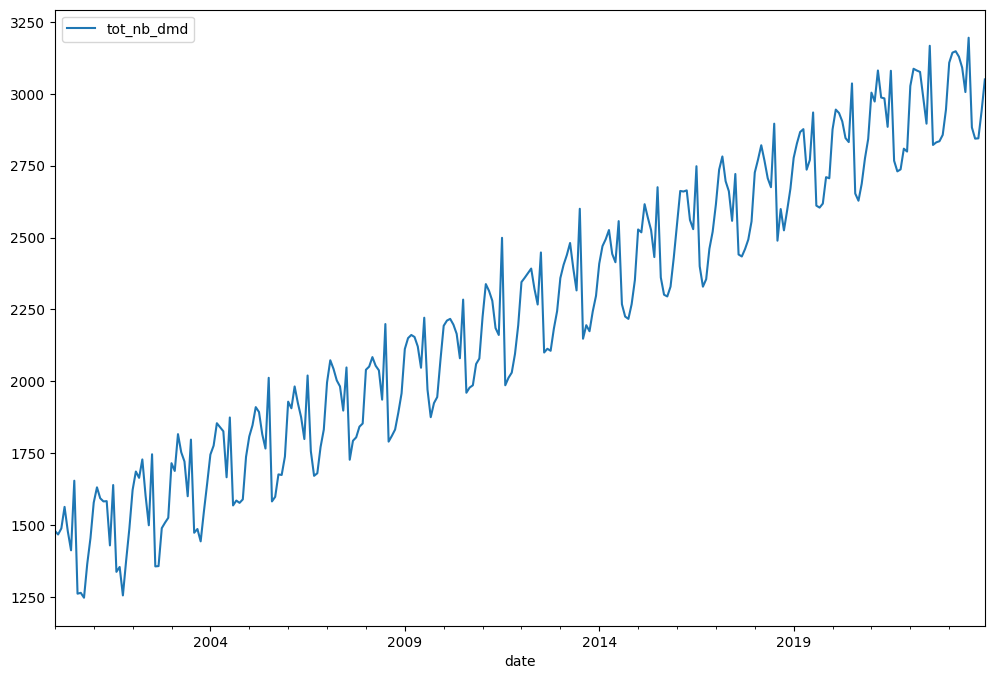

In [5]:
df.plot(figsize=(12,8))

## Répartition Entraînement / Test

**Tâche : Définition de la longueur (taille) du dataset**

In [6]:
# Créer des ensembles de train et de test
train_df, test_df = train_test_split(df, test_size=0.15, shuffle=False)

# Afficher les tailles des ensembles
print("Taille de l'ensemble d'entraînement :", len(train_df))
print("Taille de l'ensemble de test :", len(test_df))

Taille de l'ensemble d'entraînement : 244
Taille de l'ensemble de test : 44


## Mise à l'échelle des données

**Tâche : Utilisation de la classe MinMaxScaler pour mettre à l'échelle les ensembles de données d'entraînement et de test dans leurs versions mises à l'échelle.**

In [7]:
scaler = MinMaxScaler()

In [8]:
# Adapter uniquement aux données d'entraînement, sinon nous trichons en supposant des informations sur les données test
scaler.fit(train_df)

MinMaxScaler()

In [9]:
scaled_train = scaler.transform(train_df)
scaled_test = scaler.transform(test_df)

## Générateur de séries temporelles

**Tâche : Création d'un objet TimeSeriesGenerator qui se base sur les données scaled_train. La longueur du batch doit être au minimum de 12 pour saisir une saisonnalité d'une année complète.**

In [10]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [11]:
length = 12
n_features=1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

## Création du modèle avec Simple RNN

**Tâche : Création d'un modèle séquentiel de Keras avec des neurones (units).**

In [12]:
# définir le modèle
model = Sequential()
model.add(SimpleRNN(75, input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 75)             │         5,775 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            76 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,851 (22.86 KB)

 Trainable params: 5,851 (22.86 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# ajustement du modèle
model.fit(generator,epochs=5)

Epoch 1/5


232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0199
Epoch 2/5
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0031
Epoch 3/5
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0023
Epoch 4/5
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0027
Epoch 5/5
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0015


**Tâche : Traçage l'historique des pertes survenues pendant l'entraînement.**

<Axes: >

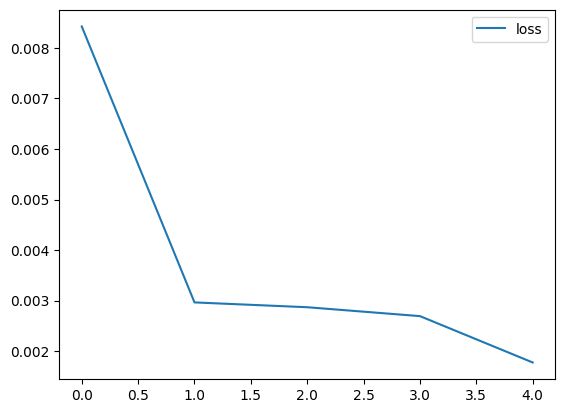

In [15]:
losses = pd.DataFrame(model.history.history)
losses.plot()

## Évaluation sur les données Test

**Tâche : Prédictions pour la gamme de données de test (les 12 derniers mois de l'ensemble des données).**

In [16]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test_df)):
    
    # obtenir la prédiction avec 1 timestamp d'avance ([0] pour ne saisir que le nombre au lieu de [array])
    current_pred = model.predict(current_batch)[0]
    
    # stocker la prédiction
    test_predictions.append(current_pred) 
    
    # mise à jour du batch pour inclure maintenant la prédiction et supprimer la première valeur
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━

In [17]:
true_predictions = scaler.inverse_transform(test_predictions)

In [18]:
test_df['Simple RNN Predictions'] = true_predictions

**Tâche : Calcul de RMSE.**

In [19]:
rmse = np.sqrt(mean_squared_error(test_df['tot_nb_dmd'],test_df['Simple RNN Predictions']))
rmse

188.45484500659137

**Tâche : Traçage vos prédictions en fonction des valeurs réels (et vrais) du test.**

<Axes: xlabel='date'>

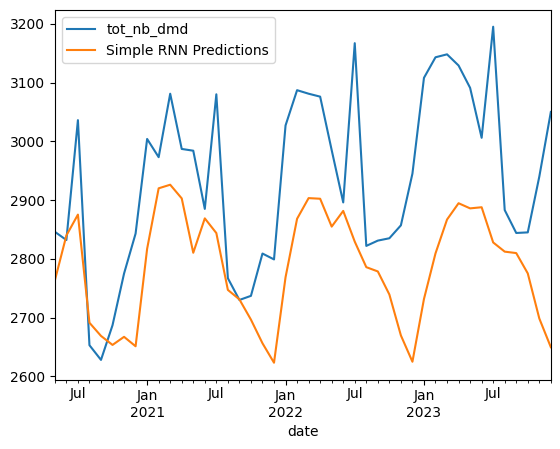

In [20]:
test_df.plot()

In [21]:
df.describe()

,tot_nb_dmd
count,288.000000
mean,2229.017361
std,498.561187
min,1247.000000
25%,1814.500000
50%,2217.000000
75%,2660.250000
max,3195.000000


# Comparaison avec LSTM

### Création du modèle avec LSTM

In [22]:
model_lstm = Sequential()
model_lstm.add(LSTM(75, input_shape=(length, n_features)))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')

In [23]:
validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length=length, batch_size=1)
early_stop = EarlyStopping(monitor='val_loss', patience=2)

model_lstm.fit(generator,epochs=15, validation_data=validation_generator, callbacks=[early_stop])

Epoch 1/15


232/232 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0320 - val_loss: 0.0071
Epoch 2/15
232/232 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0106 - val_loss: 0.0097
Epoch 3/15
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0082 - val_loss: 0.0190


<Axes: >

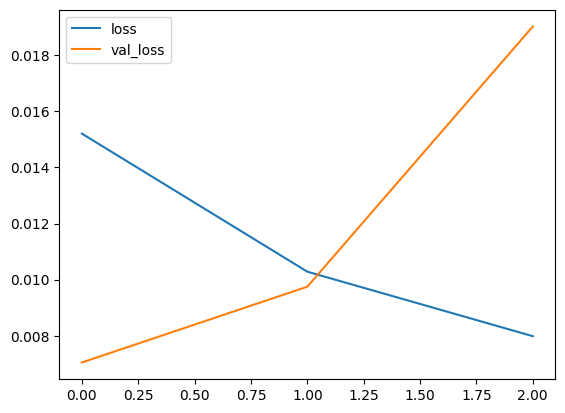

In [24]:
losses_lstm = pd.DataFrame(model_lstm.history.history)
losses_lstm.plot()

In [25]:
test_lstm_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test_df)):
    current_pred = model.predict(current_batch)[0]
    test_lstm_predictions.append(current_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

In [26]:
true_lstm_predictions = scaler.inverse_transform(test_lstm_predictions)
test_df['LSTM Predictions'] = true_lstm_predictions
rmse = np.sqrt(mean_squared_error(test_df['tot_nb_dmd'],test_df['LSTM Predictions']))
rmse

188.45484500659137

array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>], dtype=object)

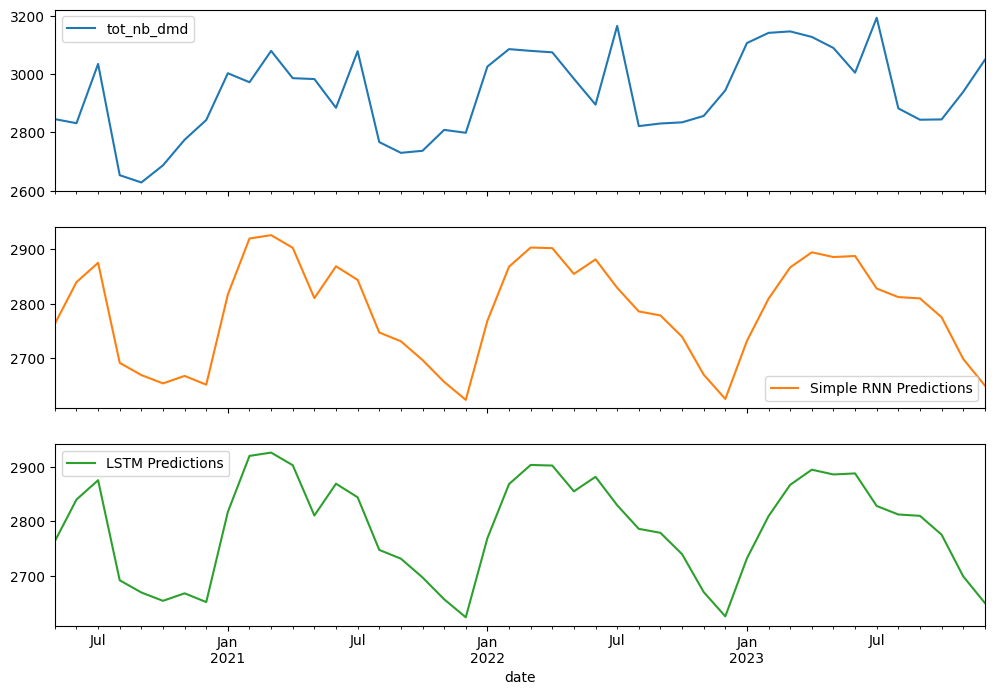

In [27]:
test_df.plot(figsize=(12,8), subplots=True)

D'après le graphe, les algorithmes LSTM & Simple RNN produisent exactement la même prédiction. Donc on peut choisir, comme algorithme, entre les deux. Cependant, LSTM est beaucoup plus sensible aux **surapprentissageset aux sous apprentissages** par rapport à algorithme de RNN simple. D'autant plus que les données utilisées sont très simple(une seule feature). En consequent, on va choisir l'algorithme de RNN simple dans la suite du travail. 

## Re-entrainement et Prévisions avec l'agorithme RNN simple
Prévisions dans un intervalle inconnu. Nous devrions d'abord utiliser toutes nos données, puisque nous faisons maintenant des prévisions !

In [28]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [29]:
# Modèle LSTM
forcast_model = Sequential()
forcast_model.add(SimpleRNN(75, input_shape=(length, n_features)))
forcast_model.add(Dense(1))
forcast_model.compile(optimizer='adam', loss='mse')
forcast_model.fit(generator,epochs=4)

Epoch 1/4


232/232 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0553
Epoch 2/4
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0032
Epoch 3/4
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0025
Epoch 4/4
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0024


In [30]:
forecast = []

# peridodes: interval de serie temporelle qu'on souhaite prédir. 
# Ici on veut avoir une prévision d'une année et demi, soit 18 mois
periods = 12
first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # obtenir la prédiction avec 1 timestamp d'avance ([0] pour ne saisir que le nombre au lieu de [array])
    current_pred = forcast_model.predict(current_batch)[0]
    
    # stocker la prédiction
    forecast.append(current_pred) 
    
    # mise à jour du batch pour inclure maintenant la prédiction et supprimer la première valeur
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [31]:
forecast = full_scaler.inverse_transform(forecast)

### Création d'un nouvel index TimeStamp avec Pandas

In [32]:
forecast_index = pd.date_range(start='2023-12-01',periods=periods,freq='MS')

In [33]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

In [34]:
forecast_df

,Forecast
2023-12-01,3182.009050
2024-01-01,3266.503231
2024-02-01,3279.393746
2024-03-01,3234.017321
2024-04-01,3183.949013
2024-05-01,3057.176914
2024-06-01,3161.471656
2024-07-01,2977.108608
2024-08-01,2959.776426
2024-09-01,2974.553959


<Axes: >

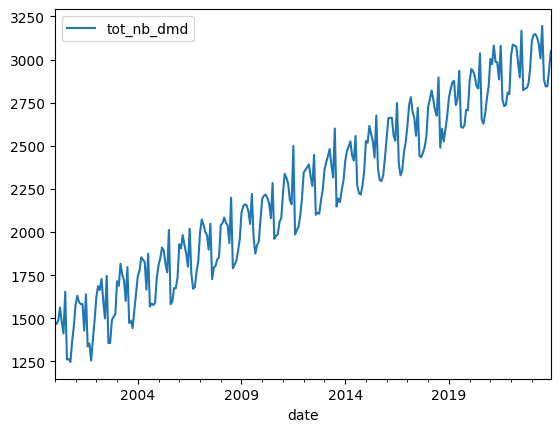

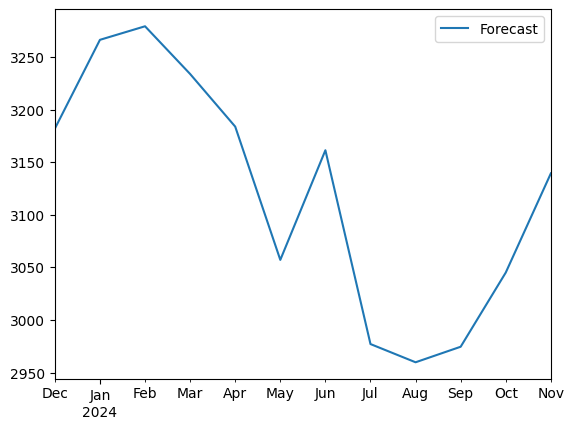

In [35]:
df.plot()
forecast_df.plot()

### Unification des graphiques avec Pandas

<Axes: xlabel='date'>

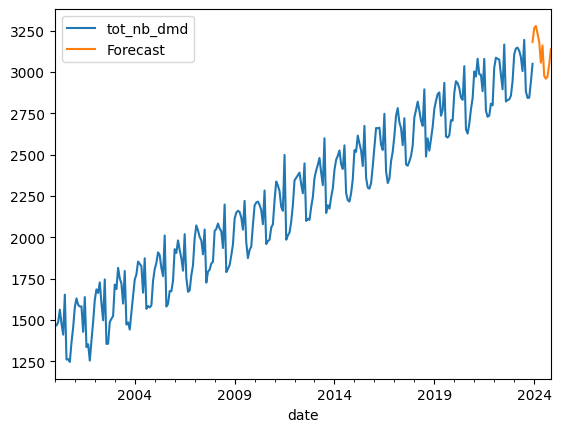

In [36]:
ax = df.plot()
forecast_df.plot(ax=ax)

(600.0, 658.0)

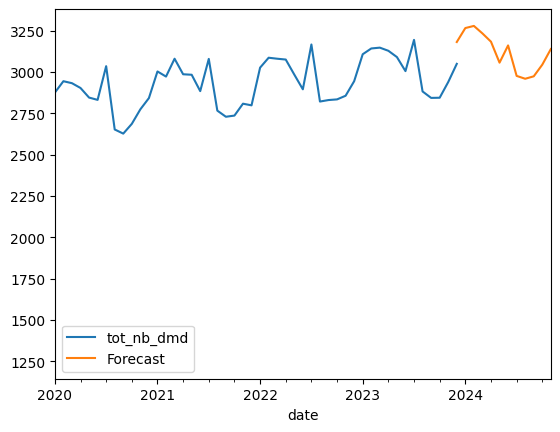

In [37]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2020-01-01','2024-11-01')

In [38]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calcul des mesures de performance sur l'ensemble de test
test_mae = mean_absolute_error(test_df['tot_nb_dmd'], true_predictions)
test_mse = mean_squared_error(test_df['tot_nb_dmd'], true_predictions)
test_rmse = mean_squared_error(test_df['tot_nb_dmd'], true_predictions, squared=False)
test_r2 = r2_score(test_df['tot_nb_dmd'], true_predictions)

# Création d'un Dataframe pour afficher les mesures de performance
perf_df = pd.DataFrame({
    'Métriques:': ['MAE', 'MSE', 'RMSE', 'R²'],
#     'Ensemble d\'entrainenemt:': [train_mae, train_mse, train_rmse, train_r2],
    'Ensemble de test:': [test_mae, test_mse, test_rmse, test_r2]
})

In [39]:
perf_df

,Métriques:,Ensemble de test:
0,MAE,152.133376
1,MSE,35515.228606
2,RMSE,188.454845
3,R²,-0.638134
